# I. Load Data

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Đường dẫn đến file Excel
file_path = r"E:\SkyRevenue Insights\0. Data\df_cleaned.xlsx"

# Kiểm tra file có tồn tại không
import os
if os.path.exists(file_path):
    print("File tồn tại!")
else:
    print("File không tồn tại, kiểm tra lại đường dẫn!")
    raise FileNotFoundError("File không tồn tại!")

# Đọc sheet "Data"
df_org = pd.read_excel(file_path)
df = df_org.copy()
# Hiển thị vài dòng đầu của DataFrame để kiểm tra
df.head()

File tồn tại!


,order_id,ticket_id,passenger_id,passenger_gender,passenger_age,ticket_source_name,ticket_status,created_date,departure_date,departure_time,...,seat_class,ticket_price,baggage,insurance_fee,discount_amount,seat_category,age_group,lead_time_days,from,to
0,20205,31268,Xs1fLinPQun+Oy/mD0FlfXMyJD38YlXJfXNbz+qO+5U=,Female,40,IOS,Paid,2023-03-01,2023-03-14,17:55:00,...,I1_ECO,867760,0,0,45000,Economy,Adults (35-59),13,Đắk Lắk,Hồ Chí Minh
1,20190,31242,m/auVlEoaGSe2MqR/Lq4CFXJnI8zauNyF/KiFmMgXHs=,Female,40,GYL,Paid,2023-03-01,2023-03-02,09:30:00,...,Z1_ECO,974280,0,0,45000,Economy,Adults (35-59),1,Đắk Lắk,Hồ Chí Minh
2,20245,31337,6HvtV2vTqUfNBJ53C4TzvJnb0s74KgcRNuUVS+8jRvU=,Female,48,IOS,Paid,2023-03-01,2023-04-10,13:10:00,...,J1_ECO,1423080,0,0,16000,Economy,Adults (35-59),40,Thừa Thiên Huế,Hồ Chí Minh
3,20259,31360,WiK2P31WEd4mckRNVWz0C2aKKRgSrauAG8NdfTLnKjE=,Male,29,Android,New,2023-03-01,2023-04-10,13:10:00,...,J1_ECO,1067310,0,0,45000,Economy,Young Adults (18-34),40,Thừa Thiên Huế,Hồ Chí Minh
4,20255,31355,6HvtV2vTqUfNBJ53C4TzvJnb0s74KgcRNuUVS+8jRvU=,Female,42,IOS,Paid,2023-03-01,2023-04-10,13:10:00,...,J1_ECO,1067310,0,0,24000,Economy,Adults (35-59),40,Thừa Thiên Huế,Hồ Chí Minh


# II. Analysis

Metrics DataFrame:


,Bookings,Net_Revenue,Cancel_Rate_%
from_to,,,
Bà Rịa-Vũng Tàu - Hà Nội,4,25678000,0.0
Bà Rịa-Vũng Tàu - Hồ Chí Minh,40,64325600,0.0
Bà Rịa-Vũng Tàu - Lâm Đồng,2,5031200,0.0
Bà Rịa-Vũng Tàu - Quảng Bình,14,30333000,0.0
Bà Rịa-Vũng Tàu - Đà Nẵng,3,4425300,0.0
...,...,...,...
Đắk Lắk - Hải Phòng,22,22943270,0.0
Đắk Lắk - Hồ Chí Minh,533,430660290,0.9
Đắk Lắk - Nghệ An,43,40032790,0.0


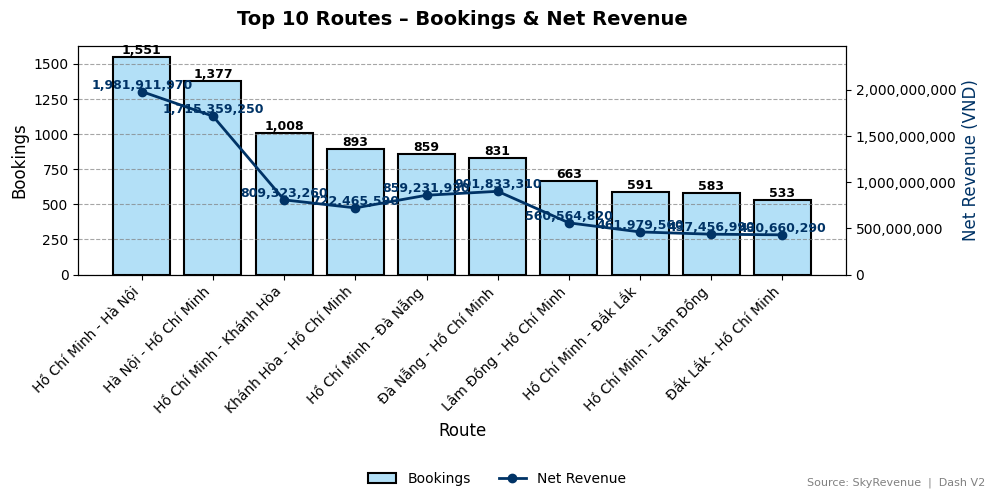

High Cancel Rate DataFrame:


,Bookings,Net_Revenue,Cancel_Rate_%
from_to,,,
Đắk Lắk - Thanh Hóa,4,6469200,50.0
Khánh Hòa - Kiên Giang,11,11486280,27.3
Kiên Giang - Khánh Hòa,25,23290440,12.0
Hà Nội - Nghệ An,23,30061500,8.7
Lâm Đồng - Nghệ An,14,12180300,7.1


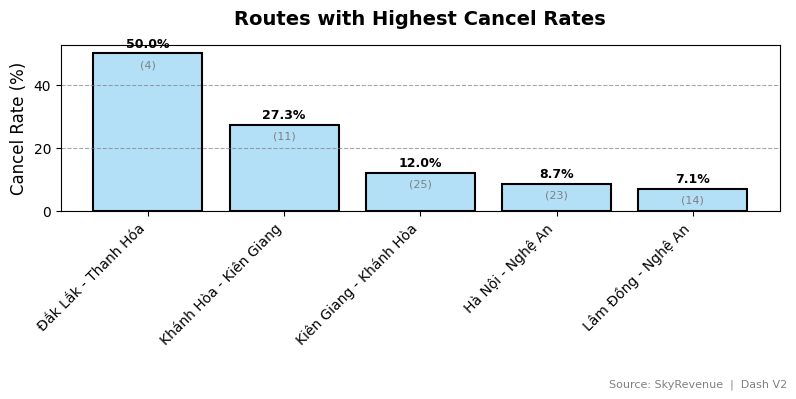

In [8]:
# ==========================================================
#        ROUTE PERFORMANCE DASHBOARD  –  Version 2
# ==========================================================

# ───────────────── 1. LOAD & PREPARE ───────────────────────
df["net_revenue"]  = df["ticket_price"] - df["discount_amount"]
df["lead_time_days"] = (df["departure_date"] - df["created_date"]).dt.days

# ---------------- ROUTE METRICS --------------------
metrics = (
    df.groupby("from_to")
      .agg(
          Bookings      = ("ticket_id", "count"),
          Net_Revenue   = ("net_revenue", "sum"),
          Paid_Count    = ("ticket_status", lambda x: (x=="Paid").sum()),
          Cancel_Count  = ("ticket_status", lambda x: (x=="Cancel").sum())
      )
)
metrics["Cancel_Rate_%"] = metrics["Cancel_Count"] / metrics["Bookings"] * 100
metrics.drop(columns=["Paid_Count","Cancel_Count"], inplace=True)
metrics = metrics.round({"Net_Revenue":0,"Cancel_Rate_%":1})

print("Metrics DataFrame:")
display(metrics)

# Top 10 by Bookings
top10 = metrics.sort_values("Bookings", ascending=False).head(10)

# -------- Chart A: Top10 Bookings (bar) + Net Revenue (line) --------
fig, ax1 = plt.subplots(figsize=(10,5))
BAR_COLOR  = "#b3e0f7"
LINE_COLOR = "#003366"
GRID_COLOR = "grey"

# Bar – Bookings
bars = ax1.bar(
    top10.index, top10["Bookings"],
    color=BAR_COLOR, edgecolor="black", linewidth=1.5, label="Bookings"
)
for bar in bars:
    ax1.text(bar.get_x()+bar.get_width()/2,
             bar.get_height()+0.8,
             f"{int(bar.get_height()):,}",
             ha="center", va="bottom",
             fontsize=9, fontweight="bold")
ax1.set_ylabel("Bookings", fontsize=12)
ax1.set_xlabel("Route", fontsize=12)
ax1.grid(True, axis="y", linestyle="--", alpha=0.7, color=GRID_COLOR)
plt.xticks(rotation=45, ha="right")

# Line – Net Revenue
ax2 = ax1.twinx()
ln = ax2.plot(
    top10.index, top10["Net_Revenue"],
    color=LINE_COLOR, marker="o", linewidth=2, label="Net Revenue"
)[0]
for x, y in zip(top10.index, top10["Net_Revenue"]):
    ax2.text(x, y, f"{int(y):,}",
             ha="center", va="bottom",
             fontsize=9, fontweight="bold", color=LINE_COLOR)
ax2.set_ylabel("Net Revenue (VND)", fontsize=12, color=LINE_COLOR)
ax2.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{int(x):,}")
)

# *** Nới trục Y của Net Revenue để tránh đụng cột ***
max_rev = top10["Net_Revenue"].max()
ax2.set_ylim(0, max_rev * 1.25)

# Title & legend
plt.title("Top 10 Routes – Bookings & Net Revenue", 
          fontsize=14, fontweight="bold", pad=15)
handles, labels = [], []
for a in (ax1, ax2):
    h,l = a.get_legend_handles_labels()
    handles+=h; labels+=l
fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False, fontsize=10)

plt.tight_layout(rect=[0,0.08,1,1])
plt.figtext(0.99,0.02,"Source: SkyRevenue  |  Dash V2", 
            ha="right", fontsize=8, color="gray")
plt.show()


# ----- Chart B: High Cancel Rate Routes with Total Bookings -----
# Top 5 by Cancel Rate
high_cancel = metrics.sort_values("Cancel_Rate_%", ascending=False).head(5)

# In bảng để kiểm tra
print("High Cancel Rate DataFrame:")
display(high_cancel)

# Vẽ chart
fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(
    high_cancel.index, high_cancel["Cancel_Rate_%"],
    color=BAR_COLOR, edgecolor="black", linewidth=1.5
)

for bar, route in zip(bars, high_cancel.index):
    pct  = high_cancel.loc[route, "Cancel_Rate_%"]
    totb = high_cancel.loc[route, "Bookings"]
    # Nhãn gồm: % ở trên cùng, tổng Bookings ngay dưới
    ax.text(
        bar.get_x() + bar.get_width()/2,
        pct + 1.0,               # offset để cao hơn cột
        f"{pct:.1f}%", 
        ha="center", va="bottom",
        fontsize=9, fontweight="bold"
    )
    ax.text(
        bar.get_x() + bar.get_width()/2,
        pct - 2.0,               # slightly below the % label
        f"({totb:,})",
        ha="center", va="top",
        fontsize=8, color="gray"
    )

ax.set_ylabel("Cancel Rate (%)", fontsize=12)
ax.set_title("Routes with Highest Cancel Rates", 
             fontsize=14, fontweight="bold", pad=15)
ax.grid(True, axis="y", linestyle="--", alpha=0.7, color=GRID_COLOR)
plt.xticks(rotation=45, ha="right")

# Footer annotation
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.figtext(
    0.99, 0.02,
    "Source: SkyRevenue  |  Dash V2",
    ha="right", fontsize=8, color="gray"
)
plt.show()


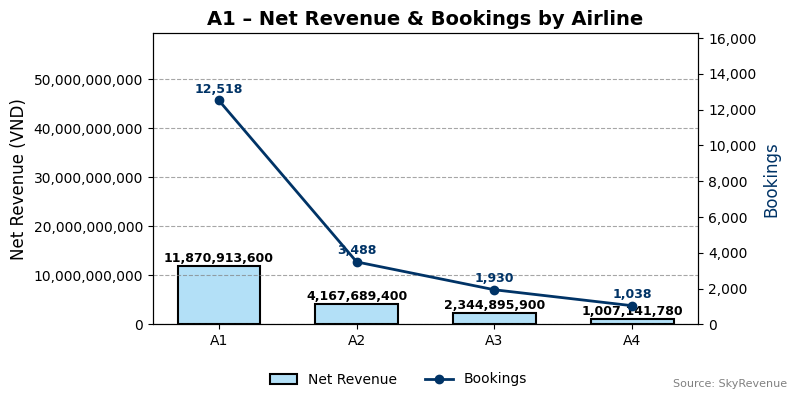

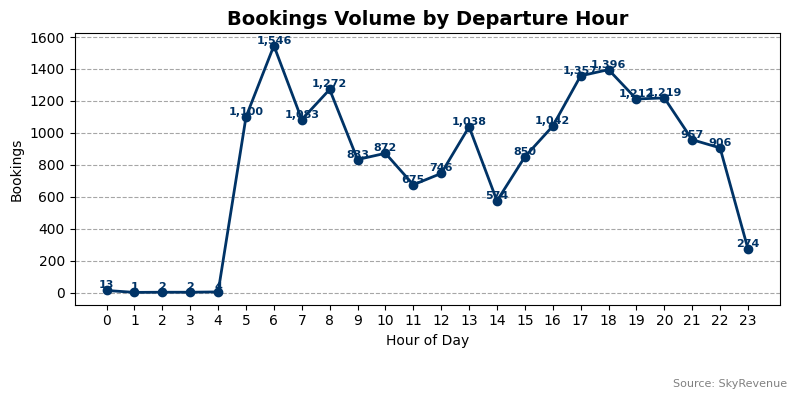

Heatmap DataFrame:


dep_hour,0,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
airline,,,,,,,,,,,,,,,,,,,,,
Ry/OjEDP12vfMWbnat5Mudc3PE4qIK/wwfCkBE5zGlM=,0.00016,0.000000,0.00016,0.00032,0.067263,0.101134,0.054002,0.080125,0.028279,0.039463,...,0.032833,0.037786,0.060872,0.064068,0.070059,0.067423,0.056718,0.046333,0.051526,0.014859
V2Ej16fVems7wWmAIxP6MCYYH+i4YSHlvuJgKvD2q8A=,0.00172,0.000573,0.00000,0.00000,0.022649,0.069954,0.077695,0.045011,0.084862,0.058773,...,0.024656,0.069667,0.042431,0.057913,0.050172,0.052466,0.072248,0.063933,0.031823,0.004874
z7BiGsH86CZWRj0PbuuLk/5jh7XcwKSaa21M2royGnA=,0.00000,0.000000,0.00000,0.00000,0.076166,0.016580,0.027979,0.056995,0.061658,0.034197,...,0.037306,0.035233,0.067876,0.052332,0.150259,0.095855,0.061140,0.047150,0.069430,0.036269


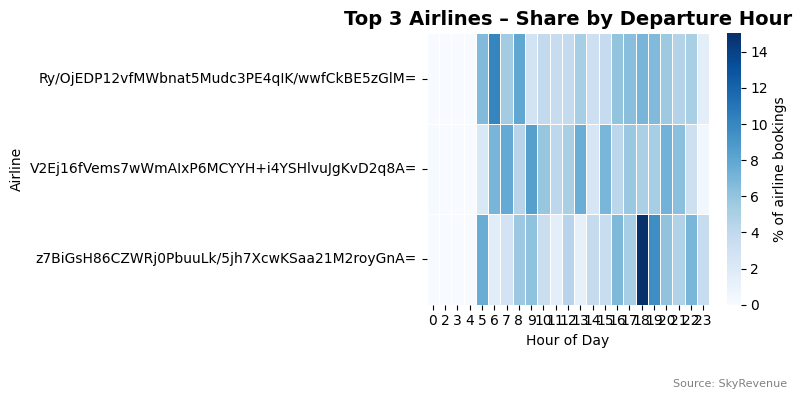

Top 5 Routes DataFrame:


,Airline,Route,Bookings
0,Ry/OjEDP12vfMWbnat5Mudc3PE4qIK/wwfCkBE5zGlM=,Hồ Chí Minh - Hà Nội,1029
1,Ry/OjEDP12vfMWbnat5Mudc3PE4qIK/wwfCkBE5zGlM=,Hà Nội - Hồ Chí Minh,896
2,Ry/OjEDP12vfMWbnat5Mudc3PE4qIK/wwfCkBE5zGlM=,Hồ Chí Minh - Khánh Hòa,710
3,Ry/OjEDP12vfMWbnat5Mudc3PE4qIK/wwfCkBE5zGlM=,Khánh Hòa - Hồ Chí Minh,691
4,Ry/OjEDP12vfMWbnat5Mudc3PE4qIK/wwfCkBE5zGlM=,Hồ Chí Minh - Đà Nẵng,510
5,V2Ej16fVems7wWmAIxP6MCYYH+i4YSHlvuJgKvD2q8A=,Hồ Chí Minh - Hà Nội,287
6,V2Ej16fVems7wWmAIxP6MCYYH+i4YSHlvuJgKvD2q8A=,Hà Nội - Hồ Chí Minh,215
7,V2Ej16fVems7wWmAIxP6MCYYH+i4YSHlvuJgKvD2q8A=,Lâm Đồng - Hồ Chí Minh,202
8,V2Ej16fVems7wWmAIxP6MCYYH+i4YSHlvuJgKvD2q8A=,Hồ Chí Minh - Đà Nẵng,174
9,V2Ej16fVems7wWmAIxP6MCYYH+i4YSHlvuJgKvD2q8A=,Hồ Chí Minh - Lâm Đồng,174


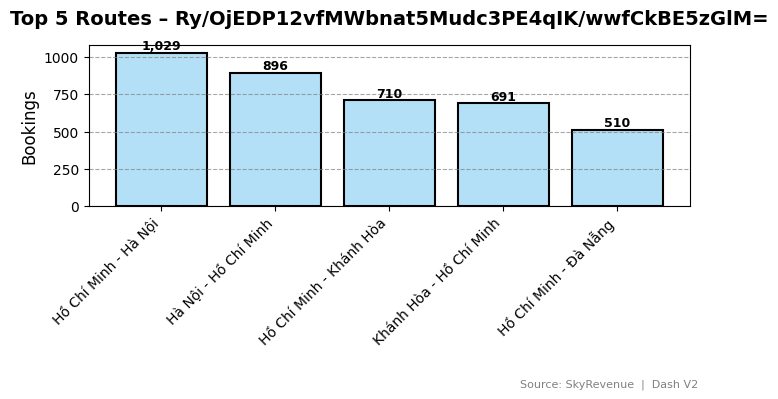

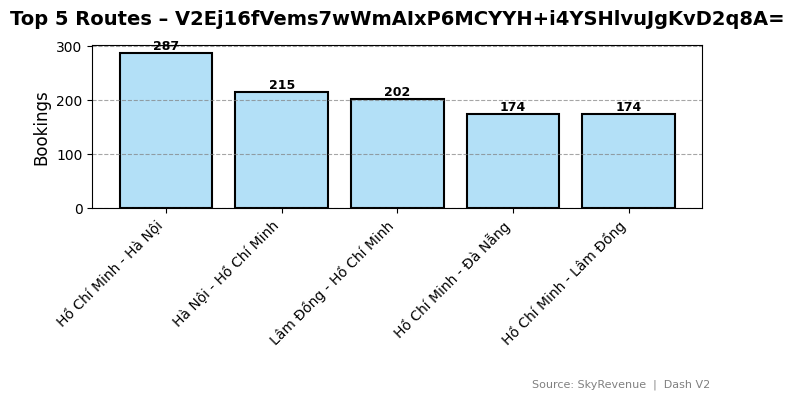

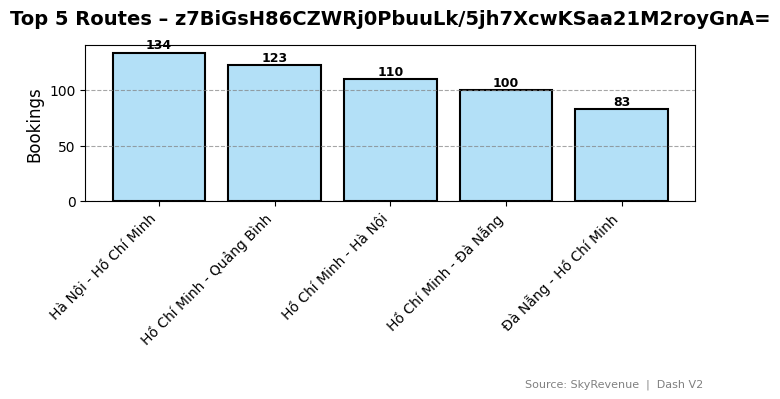

In [26]:

df["departure_time"] = pd.to_datetime(df["departure_time"], format="%H:%M:%S").dt.time
df["dep_hour"]       = df["departure_time"].apply(lambda t: t.hour)

# ─────────── Chart A1 Enhanced (Fixed Annotation) ───────────
fig, ax1 = plt.subplots(figsize=(8,4))

# Bar: Net Revenue
bars = ax1.bar(
    air_metrics.index, air_metrics["Net_Revenue"],
    color="#b3e0f7", edgecolor="black", linewidth=1.5,
    width=0.6, label="Net Revenue"
)
max_rev = air_metrics["Net_Revenue"].max()
ax1.set_ylim(0, max_rev * 5)     # nới 40% khoảng trống trên

# Annotate Net Revenue
for bar in bars:
    val = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        val + max_rev * 0.02,       # offset cố định 2% max
        f"{int(val):,}",
        ha="center", va="bottom",
        fontsize=9, fontweight="bold"
    )

ax1.set_ylabel("Net Revenue (VND)", fontsize=12)
ax1.set_title("A1 – Net Revenue & Bookings by Airline", fontsize=14, fontweight="bold")
ax1.grid(True, axis="y", linestyle="--", alpha=0.7, color="grey")
ax1.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{int(x):,}")
)

# Line: Bookings
ax2 = ax1.twinx()
ax2.plot(
    air_metrics.index, air_metrics["Bookings"],
    color="#003366", marker="o", linewidth=2, label="Bookings"
)
max_book = air_metrics["Bookings"].max()
ax2.set_ylim(0, max_book * 1.3)    # nới 30% khoảng trống trên

# Annotate Bookings
for x, y in zip(air_metrics.index, air_metrics["Bookings"]):
    ax2.text(
        x, y + max_book * 0.02,     # offset 2% max
        f"{y:,}",
        ha="center", va="bottom",
        fontsize=9, fontweight="bold", color="#003366"
    )

ax2.set_ylabel("Bookings", fontsize=12, color="#003366")
ax2.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{int(x):,}")
)

# Legend
lines, labels = [], []
for ax in (ax1, ax2):
    h, l = ax.get_legend_handles_labels()
    lines += h; labels += l
fig.legend(lines, labels, loc="lower center", ncol=2, frameon=False, fontsize=10)

plt.xticks(rotation=0, fontsize=10)
plt.tight_layout(rect=[0,0.08,1,1])
plt.figtext(0.99,0.02,"Source: SkyRevenue", ha="right", fontsize=8, color="gray")
plt.show()


# ─────────── 3. BOOKINGS BY HOUR & Chart 2 ───────────
hourly = df.groupby("dep_hour")["ticket_id"].count()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(hourly.index, hourly.values,
        color="#003366", marker="o", linewidth=2)
# Annotate every point
for x, y in zip(hourly.index, hourly.values):
    ax.text(x, y, f"{y:,}",
            ha="center", va="bottom",
            fontsize=8, fontweight="bold", color="#003366")
ax.set_title("Bookings Volume by Departure Hour",
             fontsize=14, fontweight="bold")
ax.set_xlabel("Hour of Day"); ax.set_ylabel("Bookings")
ax.grid(True, axis="y", linestyle="--", alpha=0.7, color="grey")
plt.xticks(hourly.index)
plt.tight_layout(rect=[0,0.08,1,1])
plt.figtext(0.99,0.02,"Source: SkyRevenue",ha="right",fontsize=8,color="gray")
plt.show()
# ─────────── 4. HEATMAP: Airline vs Hour ───────────
top3 = df["airline"].value_counts().head(3).index
heat_df = (
    df[df["airline"].isin(top3)]
      .groupby(["airline","dep_hour"])["ticket_id"]
      .count()
      .unstack(fill_value=0)
)
share = heat_df.div(heat_df.sum(axis=1), axis=0)

print("Heatmap DataFrame:")
display(share)



fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(
    share*100,
    cmap="Blues", cbar_kws={"label":"% of airline bookings"},
    linewidths=.5, linecolor="white", ax=ax
)
ax.set_title("Top 3 Airlines – Share by Departure Hour",
             fontsize=14, fontweight="bold")
ax.set_xlabel("Hour of Day"); ax.set_ylabel("Airline")
plt.tight_layout(rect=[0,0.08,1,1])
plt.figtext(0.99,0.02,"Source: SkyRevenue",ha="right",fontsize=8,color="gray")
plt.show()

# ─────────── 5. TOP 5 ROUTES PER AIRLINE ───────────
records = []
for airline in top3:
    top5 = (
        df[df["airline"]==airline]
          .groupby("from_to")["ticket_id"]
          .count()
          .sort_values(ascending=False)
          .head(5)
    )
    for route, cnt in top5.items():
        records.append({"Airline":airline,"Route":route,"Bookings":cnt})
top5_df = pd.DataFrame(records)

print("Top 5 Routes DataFrame:")
display(top5_df)

# ── 5.1 Bar per airline ──
for airline in top3:
    subset = top5_df[top5_df["Airline"]==airline].set_index("Route")
    fig, ax = plt.subplots(figsize=(7,4))
    bars = ax.bar(
        subset.index, subset["Bookings"],
        color=BAR_COLOR, edgecolor=EDGE_COLOR, linewidth=1.5
    )
    for bar in bars:
        ax.text(
            bar.get_x()+bar.get_width()/2,
            bar.get_height()+0.8,
            f"{int(bar.get_height()):,}",
            ha="center", va="bottom",
            fontsize=9, fontweight="bold"
        )
    ax.set_title(f"Top 5 Routes – {airline}", fontsize=14, fontweight="bold", pad=15)
    ax.set_ylabel("Bookings", fontsize=12)
    ax.grid(True, axis="y", linestyle="--", alpha=0.7, color=GRID_COLOR)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout(rect=[0,0.08,1,1])
    plt.figtext(0.99,0.02,FOOTER, ha="right", fontsize=8, color="gray")
    plt.show()
